## Deep Q Network

#### Wrappers
El entorno *PongNoFrameskip-v4* posee estados de 210x160x3 (en este entorno son imágenes), los siguientes wrappers permiten realizar diversas modificaciones a estos de tal manera que los modelos corran con mayor rapidez

In [24]:
import cv2
import gym
import gym.spaces
import collections
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn        
import torch.optim as optim
from torchsummary import summary

In [25]:
# 1. Este wrapper se queda con el máximo de cada uno de los píxeles en los dos últimos frames
# debido al efecto de parpadeo que tienen algunos juegos de Atari.
# 2. Otra acción importante que realiza, es tomar un frame cada N pasos, pues la 
# diferencia entre los fotogramas subsecuentes es mínima, y esto permite acelerar 
# el proceso de entrenamiento debido a que no se tiene que procesar cada frame.
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip
        
    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, trunc, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, trunc, info
    
    def reset(self):
        self._obs_buffer.clear()
        obs, info = self.env.reset()
        self._obs_buffer.append(obs)
        return (obs, info)
    
# Este wrapper presiona el botón FIRE para iniciar el juego
#! En la nueva versión de gym step nos devuelve 5 valores,
#! por lo que se ha modificado esa parte del código al aplicar env.step
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3
    
    def step(self, action):
        return self.env.step(action)
    
    def reset(self):
        self.env.reset()
        obs, _, done, _, info = self.env.step(1) # Presiona el botón FIRE
        if done:
            self.env.reset()
        return (obs, info)
    
    
# Este wrapper escala el frame a 84x84 y convierte el frame a escala de grises
class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
            
    def observation(self, obs):
        return ProcessFrame84.process(obs)
        
    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)
        
# Este wrapper cambia la forma de la observación de (H, W, C) a (C, H, W)
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)
        
    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)
    
# Este wrapper apila varios fotogramas seguidos (generalmente 4)
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        self.observation_space = gym.spaces.Box(env.observation_space.low.repeat(n_steps, axis=0), env.observation_space.high.repeat(n_steps, axis=0), dtype=dtype)
        
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        obs, info = self.env.reset()
        return (self.observation(self.env.reset()[0]), info)
    
    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer
    
# Este wrapper escala los valores de los píxeles a valores entre 0 y 1 y los convierte a float32
class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0

#### Clases y funciones

Clases

In [26]:

#| Clase Experience replay
class ExperienceReplay:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) # Cola de longitud máxima capacity
        
    def __len__(self):
        return len(self.buffer)
    
    def append(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):                       # Selecciona una muestra aleatoria de tamaño batch_size
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), np.array(dones, dtype=np.uint8), np.array(next_states)
    
#| Clase Agente
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state']) # Se usará para almacenar las experiencias

class Agente:
    def __init__(self, env, exp_replay):
        self.env = env
        self.exp_replay = exp_replay
        self._reset()
        
    def _reset(self):
        self.estado_actual = self.env.reset()[0]
        self.recompensa_total = 0.0
        
    def step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None                                  #! Aquí se guardará el retorno de todo el episodio
        if np.random.random() < epsilon:
            accion = self.env.action_space.sample()         #! Acción aleatoria según la política epsilon-greedy
        else:                                               #! Acción óptima según la política epsilon-greedy
            estado_ = np.array([self.estado_actual], copy=False)        # Convertir estado(imagen) a un array de numpy
            estado = torch.tensor(estado_).to(device)
            q_vals = net(estado)                                        # Procesar el estado(imagen) con la red neuronal para
                                                                        # obtener los valores Q
            _, acc_ = torch.max(q_vals, dim=1)                          # _ = valor máximo, acc_ = índice de la acción
            accion = int(acc_.item())                                   # Convertir el índice de la acción a un entero
            
        nuevo_estado, recompensa, is_done, trunc, info = self.env.step(accion)          #! Ejecutar la acción en el entorno
        self.recompensa_total += recompensa
        
        exp = Experience(self.estado_actual, accion, recompensa, is_done, nuevo_estado) # Almacenar la experiencia en una tupla
        self.exp_replay.append(exp)                           #! Añadir la tupla al buffer ExperienceReplay
        self.estado_actual = nuevo_estado
        
        if is_done:
            done_reward = self.recompensa_total
            self._reset()
        return done_reward
            

Funciones

In [27]:
# Crear entorno con los wrappers
def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)

# Crear red neuronal convolucional
def make_DQN(input_shape, output_shape):
    net = nn.Sequential(
        nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64*7*7, 512),
        nn.ReLU(),
        nn.Linear(512, output_shape)
    )
    return net

#### Entendiendo el entorno modificado con los wrappers

Forma de los estados (imágenes)

In [28]:
env = make_env("PongNoFrameskip-v4")
print('Las imágenes tienen la forma: ', env.reset()[0].shape)

Las imágenes tienen la forma:  (4, 84, 84)


c:\PYTHON\Python387\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Ejemplo de estado

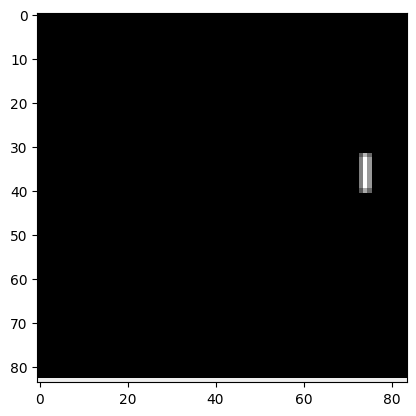

In [29]:
plt.imshow(env.reset()[0][3], cmap="gray") # Se accede al cuarto frame

#### Entrenamiento

Variables de configuración

In [30]:
import time
# Variables de configuración
env_name = "PongNoFrameskip-v4"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Condiciones
MEAN_REWARD_BOUND = 19.0            # Promedio de recompensas para considerar que el agente ha aprendido
NUMBER_OF_REWARDS_TO_AVERAGE = 10   # Número de episodios para calcular el promedio de recompensas

# Hiperparámetros
GAMMA = 0.99
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

EPS_START = 1.0
EPS_DECAY = 0.999985
EPS_MIN = 0.02

EXPERIENCE_REPLAY_SIZE = 10000      # Tamaño del buffer de experiencia
SYNC_TARGET_NETWORK = 1000          # Número de pasos para sincronizar la red objetivo con la red de entrenamiento


Iniciar entorno y redes neuronales

In [31]:
# Entorno
env = make_env(env_name)
# Redes neuronales principal y target
net = make_DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net = make_DQN(env.observation_space.shape, env.action_space.n).to(device)

# Iniciar agente y buffer de experiencia
buffer = ExperienceReplay(EXPERIENCE_REPLAY_SIZE)
agente = Agente(env, buffer)
epsilon = EPS_START
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
recompensas_totales = []
numero_frame = 0                # Contador

Bucle de Entrenamiento

In [32]:
while True:
    #| AGENTE TOMA EXPERIENCIA
    numero_frame += 1
    epsilon = max(EPS_MIN, epsilon * EPS_DECAY) # Actualizar epsilon
    
    recompensa = agente.step(net, epsilon, device=device) #! Ejecutar un paso del agente
    
    #| CUANDO ACABE EL JUEGO
    if recompensa is not None:                            #! Si el episodio ha terminado contar recompensas
        recompensas_totales.append(recompensa)
        recompensa_media = np.mean(recompensas_totales[-NUMBER_OF_REWARDS_TO_AVERAGE:])
        print(f"Frame:{numero_frame} | Total de juegos:{len(recompensas_totales)} | Recompensa Media: {recompensa_media:.3f}  (Epsilon usado ={epsilon:.2f})")
        print("%d:  %d game, recompensa media %.3f, (epsilon %.2f)" % (numero_frame, len(recompensas_totales), recompensa_media, epsilon))
        
        if recompensa_media > MEAN_REWARD_BOUND:          #! Si el promedio de recompensas es mayor que el límite terminar
            print(f"RESUELTO en {numero_frame} frames y {len(recompensas_totales)} games")
            break
        
    #| ENTRENAMIENTO
    if len(buffer) < BATCH_SIZE:                          #! Si el buffer no está lleno no entrenar
        continue
    
    batch = buffer.sample(BATCH_SIZE)                     # Obtener un batch de experiencias del buffer
    estados_, acciones_, recompensas_, dones_, estados_nuevos_ = batch
    
    # Convertir batches a tensores para que sean compatibles con la red neuronal y se entrenen con GPU
    estados = torch.tensor(estados_).to(device)
    estados_nuevos = torch.tensor(estados_nuevos_).to(device)
    acciones = torch.tensor(acciones_).to(device)
    recompensas = torch.tensor(recompensas_).to(device)
    dones = torch.tensor(dones_).to(device)
    
    # Calcular los valores Q de la red neuronal principal
    Q_values = net(estados).gather(1, acciones.unsqueeze(-1).long()).squeeze(-1) #! 1. Se procesan los estados
                                                                                 #! 2. Gather: Se seleccionan los valores Q de las acciones tomadas anteriormente
                                                                                 #! 3. squeeze(-1): Se elimina la dimensión de tamaño 1
    
    # Calcular los valores Q de la red neuronal target
    valores_nuevo_estado = target_net(estados_nuevos).max(1)[0]
    valores_nuevo_estado[dones] = 0.0   # Si el episodio ha terminado no se tiene en cuenta el valor del nuevo estado
    valores_nuevo_estado = valores_nuevo_estado.detach() # No se calculan los gradientes de los valores del nuevo estado debido a que no se van a entrenar
    
    # Calcular los valores Q esperados
    expected_Q_values = recompensas + GAMMA * valores_nuevo_estado
    # Calcular el error
    loss = nn.MSELoss()(Q_values, expected_Q_values)
    
    #| MODIFICAR LOS PESOS DE LA RED NEURONAL
    optimizer.zero_grad() # Coloca los gradientes a cero
    loss.backward()       # Calcula los gradientes
    optimizer.step()      # Actualiza los pesos
    
    #| SINCRONIZAR LA RED TARGET
    if numero_frame % SYNC_TARGET_NETWORK == 0:
        target_net.load_state_dict(net.state_dict())
        
# Guardar el modelo
torch.save(net.state_dict(), "Practica7_Q_Network.dat")

C:\Users\USER\AppData\Local\Temp\ipykernel_7164\3198339802.py:40: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Indexing.cu:1441.)
  valores_nuevo_estado[dones] = 0.0   # Si el episodio ha terminado no se tiene en cuenta el valor del nuevo estado


Frame:1149 | Total de juegos:1 | Recompensa Media: -19.000  (Epsilon usado =0.98)
1149:  1 game, recompensa media -19.000, (epsilon 0.98)
Frame:1912 | Total de juegos:2 | Recompensa Media: -20.000  (Epsilon usado =0.97)
1912:  2 game, recompensa media -20.000, (epsilon 0.97)
Frame:2841 | Total de juegos:3 | Recompensa Media: -20.000  (Epsilon usado =0.96)
2841:  3 game, recompensa media -20.000, (epsilon 0.96)
Frame:3808 | Total de juegos:4 | Recompensa Media: -20.000  (Epsilon usado =0.94)
3808:  4 game, recompensa media -20.000, (epsilon 0.94)
Frame:4659 | Total de juegos:5 | Recompensa Media: -20.200  (Epsilon usado =0.93)
4659:  5 game, recompensa media -20.200, (epsilon 0.93)
Frame:5558 | Total de juegos:6 | Recompensa Media: -20.167  (Epsilon usado =0.92)
5558:  6 game, recompensa media -20.167, (epsilon 0.92)
Frame:6694 | Total de juegos:7 | Recompensa Media: -19.857  (Epsilon usado =0.90)
6694:  7 game, recompensa media -19.857, (epsilon 0.90)
Frame:7517 | Total de juegos:8 | R